In [1]:
 ## all packages
 ! pip install gymnasium[all]
 !apt-get install git
 !git clone https://github.com/magni84/gym_RLcourse.git
 %cd gym_RLcourse
 !pip install -e .
 !pip install matplotlib
 !pip install pygame

 ! pip install gymnasium 'gymnasium[atari]' 'gymnasium[accept-rom-license]'


 import gym_RLcourse
 import numpy as np
 import matplotlib
 import matplotlib.pyplot as plt
 from IPython.display import clear_output # Used to clear the ouput of a Jupyter cell.

 from collections import namedtuple, deque
 from itertools import count
 import math
 import random

 ### Torch imports
 import torch
 # from torch import nn
 from torch.utils.data import DataLoader
 from torchvision import datasets
 from torchvision.transforms import ToTensor

 import torch.nn as nn
 import torch.nn.functional as F
 import argparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 30.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-many

In [4]:
# import torch
# import torch.nn as nn
import torch.optim as optim
# import random
# import numpy as np
import gym
# import torch.nn.functional as F
# import argparse

args = argparse.Namespace(
    env='CartPole-v1',
    evaluate_freq=2,
    evaluation_episodes=1000
)
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def __len__(self):
        return len(self.memory)

    def push(self, obs, action, next_obs, reward, donne):
        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.position] = (obs, action, reward, next_obs, donne)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """
        Samples batch_size transitions from the replay memory and returns a tuple
            (obs, action, next_obs, reward)
        """
        sample = random.sample(self.memory, batch_size)
        return zip(*sample)

# Initialize environment and agent
env = gym.make('CartPole-v1')
# env = gym.wrappers.RecordVideo(env, './video/', episode_trigger=lambda episode_id: True)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n




CartPole = {
    'memory_size': 50000,
    'n_episodes': 200,
    'batch_size': 32,
    'target_update_frequency': 100,
    'train_frequency': 1,
    'gamma': 0.99,
    'lr': 1e-3,
    'eps_start': 1.0,
    'eps_end': 0.01,
    'anneal_length': 10**4,
    'n_actions': 2,
    'epsilon': 0.9
}
ENV_CONFIGS = {
    'CartPole-v1': CartPole
}

env_config = ENV_CONFIGS['CartPole-v1']
replay_memory = ReplayMemory(env_config['memory_size'])


# Define the Q-network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
    def forward(self, x):
        # print('x: ',x.shape)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_network = QNetwork(state_size, action_size).to(device)
target_network = QNetwork(state_size, action_size).to(device)
target_network.load_state_dict(q_network.state_dict())
target_network.eval()

def evaluate_policy(agent, env, env_config, args, n_episodes, render=False, verbose=False):
    """Runs {n_episodes} episodes to evaluate current policy."""
    total_return = 0
    for i in range(n_episodes):
        state = env.reset()
        #state = preprocess(obs, env=args.env).unsqueeze(0)

        terminated = False
        episode_return = 0
        truncated = False
        while not terminated and not truncated:
            if render:
                env.render()

            action = agent.act(state, exploit=True)
            state, reward, terminated, truncated = env.step(action)
            #obs = preprocess(obs, env=args.env).unsqueeze(0)

            episode_return += reward

        total_return += episode_return

        if verbose:
            print(f'Finished episode {i+1} with a total return of {episode_return}')


    return total_return / n_episodes
# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size, lr=env_config["lr"], gamma=env_config["gamma"], epsilon_start=env_config['eps_start'], epsilon_end=env_config['eps_end'], epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.optimizer = optim.Adam(q_network.parameters(), lr=lr)
        self.loss_function = F.mse_loss

    def act(self, state, exploit = False):
      if exploit or random.random() > self.epsilon:
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = q_network(state)
            action = q_values.argmax().item()

      else:
        action = random.randrange(self.action_size)

      return action
      #  else:
      #    with torch.no_grad():
      #             state = torch.FloatTensor(state).unsqueeze(0).to(device)
      #             q_values = q_network(state)
      #             action = q_values.argmax().item()
      #             return action


    def optimize(self, state, action, reward, next_state, done, batch_size=32, step = 1):
        if len(replay_memory) < batch_size:
            return

        states, actions, next_states, rewards, dones = replay_memory.sample(batch_size)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_values = q_network(states).gather(1, actions)
        next_q_values = target_network(next_states).max(dim=1, keepdim=True)[0].detach()
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.loss_function(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        if step % env_config['target_update_frequency']:
            target_network.load_state_dict(q_network.state_dict())

        # Update epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)



agent = DQNAgent(state_size, action_size)
# Training parameters
n_episodes = env_config['n_episodes']
batch_size = 32

returns = []
trailing_avg_returns = []
episodes = list(range(1, n_episodes + 1))
for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0
    step = 1
    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        replay_memory.push(state, action, reward, next_state, done)
        total_reward += reward

        agent.optimize(state, action, reward, next_state, done, batch_size, step)
        step += 1
        state = next_state

        if done or _:
            break
    env.close()

    returns.append(total_reward)

    if len(returns) >= 20:
        average = sum(returns[-20:]) / 20
        trailing_avg_returns.append(average)
    else:
        average = sum(returns) / len(returns)
        trailing_avg_returns.append(average)

    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")
    print(average)
    #print(evaluate_policy(agent, env, env_config, args, args.evaluation_episodes))

env.close()


Episode: 1, Total Reward: 24.0
24.0
Episode: 2, Total Reward: 29.0
26.5
Episode: 3, Total Reward: 17.0
23.333333333333332
Episode: 4, Total Reward: 10.0
20.0
Episode: 5, Total Reward: 19.0
19.8
Episode: 6, Total Reward: 26.0
20.833333333333332
Episode: 7, Total Reward: 13.0
19.714285714285715
Episode: 8, Total Reward: 15.0
19.125
Episode: 9, Total Reward: 16.0
18.77777777777778
Episode: 10, Total Reward: 16.0
18.5
Episode: 11, Total Reward: 15.0
18.181818181818183
Episode: 12, Total Reward: 14.0
17.833333333333332
Episode: 13, Total Reward: 12.0
17.384615384615383
Episode: 14, Total Reward: 17.0
17.357142857142858
Episode: 15, Total Reward: 11.0
16.933333333333334
Episode: 16, Total Reward: 12.0
16.625
Episode: 17, Total Reward: 13.0
16.41176470588235
Episode: 18, Total Reward: 11.0
16.11111111111111
Episode: 19, Total Reward: 14.0
16.0
Episode: 20, Total Reward: 15.0
15.95
Episode: 21, Total Reward: 11.0
15.3
Episode: 22, Total Reward: 9.0
14.3
Episode: 23, Total Reward: 10.0
13.95
Ep

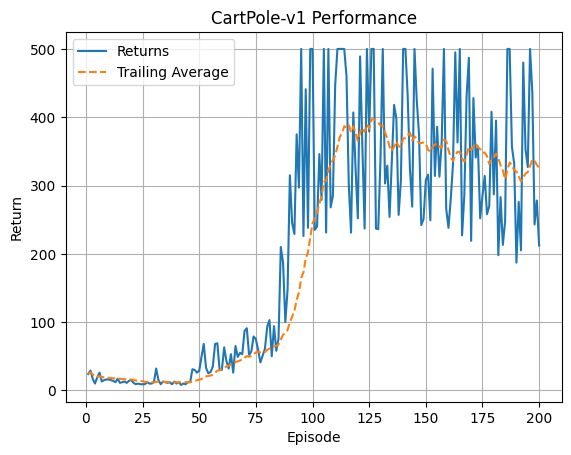

In [5]:
import matplotlib.pyplot as plt

plt.plot(episodes, returns, label='Returns')
plt.plot(episodes, trailing_avg_returns, label='Trailing Average', linestyle='--')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('CartPole-v1 Performance')
plt.legend()
plt.grid(True)
plt.show()